In [1]:
from dask.distributed import LocalCluster, Client 
 
def create_connection():
    cluster = LocalCluster(n_workers=2, threads_per_worker=1, processes=True, memory_limit="2GiB")
    client = Client(cluster)
    return client

In [2]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt



# --- Define constants ---
mpi = 139.57  # Mass of a pion in MeV
mK = 493.677  # Mass of a kaon in MeV
mB = 5279.64  # Mass of a B meson in MeV
mD = 1869.65  # Mass of a D meson in MeV

# Define the probability cut variables (same as original)
probK_all = 0.5
probK_max = 0.5
probpi_all = 0.5
probK_high = 0.5
mass_cut = 100
mass_cut_D = 100

# Define the sum variables
probK_sum = 1.5    # Sum of three kaon probabilities
probpi_sum = 1.5   # Sum of three pion probabilities
probpi_sum2 = 1.0  # Sum of two pion probabilities

/home/siliataider/Documents/root/rootbuild/py-rdf-pyroot-debug/lib/cppyy_backend/loader.py:147: UserWarning: No precompiled header available (cannot import name 'get_cppversion' from 'cppyy_backend._get_cppflags' (/home/siliataider/Documents/root/rootbuild/py-rdf-pyroot-debug/lib/cppyy_backend/_get_cppflags.py)); this may impact performance.
  warnings.warn('No precompiled header available (%s); this may impact performance.' % msg)
input_line_14:1:64: error: redefinition of 'is_equal'
namespace __cppyy_internal { template<class C1, class C2> bool is_equal(const C1& c1, const C2& c2) { return (bool)(c1 == c2); } }
                                                               ^
input_line_10:1:64: note: previous definition is here
namespace __cppyy_internal { template<class C1, class C2> bool is_equal(const C1& c1, const C2& c2) { return (bool)(c1 == c2); } }
                                                               ^
input_line_15:1:64: error: redefinition of 'is_not_equal'
namesp

In [3]:
print("Starting RDataFrame processing with two files...")

# Enable implicit multi-threading for RDataFrame
ROOT.EnableImplicitMT()

# Create a TChain to combine both files
chain = ROOT.TChain("DecayTree")
chain.Add("../data/B2HHH_MagnetDown.root")
chain.Add("../data/B2HHH_MagnetUp.root")

# Load the combined data using RDataFrame
connection = create_connection()
df = ROOT.RDataFrame(chain, executor=connection)

# First, let's check the total number of events from both files
total_events = df.Count()
# print(f"Total events in combined files: {total_events}")

# --- Define derived quantities (exactly matching the uproot code) ---

# Define pT calculations
df = df.Define("pT_H1", "sqrt(H1_PX*H1_PX + H1_PY*H1_PY)")
df = df.Define("pT_H2", "sqrt(H2_PX*H2_PX + H2_PY*H2_PY)")
df = df.Define("pT_H3", "sqrt(H3_PX*H3_PX + H3_PY*H3_PY)")

# Define energy calculations for pions
df = df.Define("e_pi1", f"sqrt(H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ + {mpi*mpi})")\
       .Define("e_pi2", f"sqrt(H2_PX*H2_PX + H2_PY*H2_PY + H2_PZ*H2_PZ + {mpi*mpi})")\
       .Define("e_pi3", f"sqrt(H3_PX*H3_PX + H3_PY*H3_PY + H3_PZ*H3_PZ + {mpi*mpi})")

# Define energy calculations for kaons
df = df.Define("e_K1", f"sqrt(H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ + {mK*mK})")\
       .Define("e_K2", f"sqrt(H2_PX*H2_PX + H2_PY*H2_PY + H2_PZ*H2_PZ + {mK*mK})")\
       .Define("e_K3", f"sqrt(H3_PX*H3_PX + H3_PY*H3_PY + H3_PZ*H3_PZ + {mK*mK})")

# Define momentum squared calculations
df = df.Define("p12sq", "(H1_PX + H2_PX)*(H1_PX + H2_PX) + (H1_PY + H2_PY)*(H1_PY + H2_PY) + (H1_PZ + H2_PZ)*(H1_PZ + H2_PZ)")\
       .Define("p23sq", "(H2_PX + H3_PX)*(H2_PX + H3_PX) + (H2_PY + H3_PY)*(H2_PY + H3_PY) + (H2_PZ + H3_PZ)*(H2_PZ + H3_PZ)")\
       .Define("p13sq", "(H1_PX + H3_PX)*(H1_PX + H3_PX) + (H1_PY + H3_PY)*(H1_PY + H3_PY) + (H1_PZ + H3_PZ)*(H1_PZ + H3_PZ)")\
       .Define("psq", "(H1_PX + H2_PX + H3_PX)*(H1_PX + H2_PX + H3_PX) + (H1_PY + H2_PY + H3_PY)*(H1_PY + H2_PY + H3_PY) + (H1_PZ + H2_PZ + H3_PZ)*(H1_PZ + H2_PZ + H3_PZ)")

# Define mass squared calculations for KK pairs
df = df.Define("m12KKsq", "(e_K1 + e_K2)*(e_K1 + e_K2) - p12sq")\
       .Define("m23KKsq", "(e_K2 + e_K3)*(e_K2 + e_K3) - p23sq")\
       .Define("m13KKsq", "(e_K1 + e_K3)*(e_K1 + e_K3) - p13sq")

# Define mass squared calculations for pipi pairs
df = df.Define("m12pipisq", "(e_pi1 + e_pi2)*(e_pi1 + e_pi2) - p12sq")\
       .Define("m23pipisq", "(e_pi2 + e_pi3)*(e_pi2 + e_pi3) - p23sq")\
       .Define("m13pipisq", "(e_pi1 + e_pi3)*(e_pi1 + e_pi3) - p13sq")

# Define mass squared calculations for Kpi pairs
df = df.Define("m12Kpisq", "(e_K1 + e_pi2)*(e_K1 + e_pi2) - p12sq")\
       .Define("m23Kpisq", "(e_K2 + e_pi3)*(e_K2 + e_pi3) - p23sq")\
       .Define("m13Kpisq", "(e_K1 + e_pi3)*(e_K1 + e_pi3) - p13sq")\
       .Define("m12piKsq", "(e_pi1 + e_K2)*(e_pi1 + e_K2) - p12sq")\
       .Define("m23piKsq", "(e_pi2 + e_K3)*(e_pi2 + e_K3) - p23sq")\
       .Define("m13piKsq", "(e_pi1 + e_K3)*(e_pi1 + e_K3) - p13sq")

# Define invariant mass calculations
df = df.Define("mKKKinv", "sqrt((e_K1 + e_K2 + e_K3)*(e_K1 + e_K2 + e_K3) - psq)")\
       .Define("mpipipiinv", "sqrt((e_pi1 + e_pi2 + e_pi3)*(e_pi1 + e_pi2 + e_pi3) - psq)")\
       .Define("mKpipiinv", "sqrt((e_K1 + e_pi2 + e_pi3)*(e_K1 + e_pi2 + e_pi3) - psq)")\
       .Define("mpiKpiinv", "sqrt((e_pi1 + e_K2 + e_pi3)*(e_pi1 + e_K2 + e_pi3) - psq)")\
       .Define("mpipiKinv", "sqrt((e_pi1 + e_pi2 + e_K3)*(e_pi1 + e_pi2 + e_K3) - psq)")      
print("Derived quantities defined")


Starting RDataFrame processing with two files...
Derived quantities defined


Warning in <EnableImplicitMT>: Cannot enable implicit multi-threading with 0 threads, please build ROOT with -Dimt=ON


In [4]:
# --- Apply basic selection cuts ---
print("Applying basic selection criteria...")

# Filter basic cuts
df_basic = df.Filter("H1_PZ > 0 && H2_PZ > 0 && H3_PZ > 0", "Positive PZ")\
             .Filter("!H1_isMuon && !H2_isMuon && !H3_isMuon", "Not muons")

    
basic_events = df_basic.Count()
# print(f"Events after basic cuts: {basic_events}")


Applying basic selection criteria...


In [5]:
# --- Add missing histogram variables definitions ---

# Define mKKlow and mKKhigh for KKK histograms (matching original logic exactly)
df_basic = df_basic.Define("mKKlow", f"""
    double result = -999.0;
    bool in_mass_window = abs(mKKKinv - {mB}) < {mass_cut};
    bool probK_cuts = (H1_ProbK > {probK_all} && H2_ProbK > {probK_all} && H3_ProbK > {probK_all} && 
                       H1_ProbK + H2_ProbK + H3_ProbK > {probK_sum});
    
    if (probK_cuts && in_mass_window) {{
        if (H1_Charge == H2_Charge) {{
            if (m13KKsq > m23KKsq) {{
                result = sqrt(m23KKsq);
            }} else {{
                result = sqrt(m13KKsq);
            }}
        }} else if (H1_Charge == H3_Charge) {{
            if (m12KKsq > m23KKsq) {{
                result = sqrt(m23KKsq);
            }} else {{
                result = sqrt(m12KKsq);
            }}
        }} else if (H2_Charge == H3_Charge) {{
            if (m12KKsq > m13KKsq) {{
                result = sqrt(m13KKsq);
            }} else {{
                result = sqrt(m12KKsq);
            }}
        }}
    }}
    return result;
""")

df_basic = df_basic.Define("mKKhigh", f"""
    double result = -999.0;
    bool in_mass_window = abs(mKKKinv - {mB}) < {mass_cut};
    bool probK_cuts = (H1_ProbK > {probK_all} && H2_ProbK > {probK_all} && H3_ProbK > {probK_all} && 
                       H1_ProbK + H2_ProbK + H3_ProbK > {probK_sum});
    
    if (probK_cuts && in_mass_window) {{
        if (H1_Charge == H2_Charge) {{
            result = sqrt(m12KKsq);
        }} else if (H1_Charge == H3_Charge) {{
            result = sqrt(m13KKsq);
        }} else if (H2_Charge == H3_Charge) {{
            result = sqrt(m23KKsq);
        }}
    }}
    return result;
""")

# Define mpipilow and mpipihigh for πππ histograms (matching original logic exactly)
df_basic = df_basic.Define("mpipilow", f"""
    double result = -999.0;
    bool in_mass_window = abs(mpipipiinv - {mB}) < {mass_cut};
    bool probPi_cuts = (H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
                        H1_ProbK < {probK_max} && H2_ProbK < {probK_max} && H3_ProbK < {probK_max} &&
                        H1_ProbPi + H2_ProbPi + H3_ProbPi > {probpi_sum});
    
    if (probPi_cuts && in_mass_window) {{
        if (H1_Charge == H2_Charge) {{
            if (m13pipisq > m23pipisq) {{
                result = sqrt(m23pipisq);
            }} else {{
                result = sqrt(m13pipisq);
            }}
        }} else if (H1_Charge == H3_Charge) {{
            if (m12pipisq > m23pipisq) {{
                result = sqrt(m23pipisq);
            }} else {{
                result = sqrt(m12pipisq);
            }}
        }} else if (H2_Charge == H3_Charge) {{
            if (m12pipisq > m13pipisq) {{
                result = sqrt(m13pipisq);
            }} else {{
                result = sqrt(m12pipisq);
            }}
        }}
    }}
    return result;
""")

df_basic = df_basic.Define("mpipihigh", f"""
    double result = -999.0;
    bool in_mass_window = abs(mpipipiinv - {mB}) < {mass_cut};
    bool probPi_cuts = (H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
                        H1_ProbK < {probK_max} && H2_ProbK < {probK_max} && H3_ProbK < {probK_max} &&
                        H1_ProbPi + H2_ProbPi + H3_ProbPi > {probpi_sum});
    
    if (probPi_cuts && in_mass_window) {{
        if (H1_Charge == H2_Charge) {{
            if (m13pipisq > m23pipisq) {{
                result = sqrt(m13pipisq);
            }} else {{
                result = sqrt(m23pipisq);
            }}
        }} else if (H1_Charge == H3_Charge) {{
            if (m12pipisq > m23pipisq) {{
                result = sqrt(m12pipisq);
            }} else {{
                result = sqrt(m23pipisq);
            }}
        }} else if (H2_Charge == H3_Charge) {{
            if (m12pipisq > m13pipisq) {{
                result = sqrt(m12pipisq);
            }} else {{
                result = sqrt(m13pipisq);
            }}
        }}
    }}
    return result;
""")

# Define mKpi for Kππ histograms (matching original logic exactly)
df_basic = df_basic.Define("mKpi", f"""
    double result = -999.0;
    double max_probK = std::max({{H1_ProbK, H2_ProbK, H3_ProbK}});
    int kpi_case = 0;
    
    // Determine which case applies (matching original logic)
    if (H1_ProbK == max_probK && H1_ProbK > {probK_high} &&
        H2_Charge != H3_Charge &&
        H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
        (H2_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        kpi_case = 1;
    }} else if (H2_ProbK == max_probK && H2_ProbK > {probK_high} &&
               H1_Charge != H3_Charge &&
               H1_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
               (H1_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        kpi_case = 2;
    }} else if (H3_ProbK == max_probK && H3_ProbK > {probK_high} &&
               H1_Charge != H2_Charge &&
               H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} &&
               (H1_ProbPi + H2_ProbPi) > {probpi_sum2}) {{
        kpi_case = 3;
    }}
    
    bool in_mass_window = false;
    if (kpi_case == 1) {{
        in_mass_window = abs(mKpipiinv - {mB}) < {mass_cut};
        if (in_mass_window) {{
            if (H1_Charge != H2_Charge) {{
                result = sqrt(m12Kpisq);
            }} else {{
                result = sqrt(m13Kpisq);
            }}
        }}
    }} else if (kpi_case == 2) {{
        in_mass_window = abs(mpiKpiinv - {mB}) < {mass_cut};
        if (in_mass_window) {{
            if (H2_Charge != H1_Charge) {{
                result = sqrt(m12piKsq);
            }} else {{
                result = sqrt(m23Kpisq);
            }}
        }}
    }} else if (kpi_case == 3) {{
        in_mass_window = abs(mpipiKinv - {mB}) < {mass_cut};
        if (in_mass_window) {{
            if (H3_Charge != H1_Charge) {{
                result = sqrt(m13piKsq);
            }} else {{
                result = sqrt(m23piKsq);
            }}
        }}
    }}
    
    return result;
""")

# Define mpipi for Kππ histograms (matching original logic exactly)
df_basic = df_basic.Define("mpipi", f"""
    double result = -999.0;
    double max_probK = std::max({{H1_ProbK, H2_ProbK, H3_ProbK}});
    int kpi_case = 0;
    
    // Determine which case applies (matching original logic)
    if (H1_ProbK == max_probK && H1_ProbK > {probK_high} &&
        H2_Charge != H3_Charge &&
        H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
        (H2_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        kpi_case = 1;
    }} else if (H2_ProbK == max_probK && H2_ProbK > {probK_high} &&
               H1_Charge != H3_Charge &&
               H1_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
               (H1_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        kpi_case = 2;
    }} else if (H3_ProbK == max_probK && H3_ProbK > {probK_high} &&
               H1_Charge != H2_Charge &&
               H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} &&
               (H1_ProbPi + H2_ProbPi) > {probpi_sum2}) {{
        kpi_case = 3;
    }}
    
    bool in_mass_window = false;
    if (kpi_case == 1) {{
        in_mass_window = abs(mKpipiinv - {mB}) < {mass_cut};
        if (in_mass_window) {{
            result = sqrt(m23pipisq);
        }}
    }} else if (kpi_case == 2) {{
        in_mass_window = abs(mpiKpiinv - {mB}) < {mass_cut};
        if (in_mass_window) {{
            result = sqrt(m13pipisq);
        }}
    }} else if (kpi_case == 3) {{
        in_mass_window = abs(mpipiKinv - {mB}) < {mass_cut};
        if (in_mass_window) {{
            result = sqrt(m12pipisq);
        }}
    }}
    
    return result;
""")

print("Missing histogram variables defined")

# --- KKK Selection ---
print("Applying KKK selection...")

df_kkk = df_basic.Filter(f"H1_ProbK > {probK_all} && H2_ProbK > {probK_all} && H3_ProbK > {probK_all}", "KKK_ProbK_all")\
                 .Filter(f"H1_ProbK + H2_ProbK + H3_ProbK > {probK_sum}", "KKK_ProbK_sum")

# Define KKK mass selection with charge logic
df_kkk = df_kkk.Define("KKK_valid_mass", f"""
    double result = -999.0;
    bool mass_cut_ok = false;
    bool d_veto_ok = false;
    
    // H1-H2 same charge
    if (H1_Charge == H2_Charge) {{
        if (m13KKsq > m23KKsq) {{
            if (abs(mKKKinv - {mB}) < {mass_cut}) mass_cut_ok = true;
            if (abs(sqrt(m23KKsq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
        }} else {{
            if (abs(mKKKinv - {mB}) < {mass_cut}) mass_cut_ok = true;
            if (abs(sqrt(m13KKsq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
        }}
    }}
    // H1-H3 same charge
    else if (H1_Charge == H3_Charge) {{
        if (m12KKsq > m23KKsq) {{
            if (abs(mKKKinv - {mB}) < {mass_cut}) mass_cut_ok = true;
            if (abs(sqrt(m23KKsq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
        }} else {{
            if (abs(mKKKinv - {mB}) < {mass_cut}) mass_cut_ok = true;
            if (abs(sqrt(m12KKsq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
        }}
    }}
    // H2-H3 same charge
    else if (H2_Charge == H3_Charge) {{
        if (m12KKsq > m13KKsq) {{
            if (abs(mKKKinv - {mB}) < {mass_cut}) mass_cut_ok = true;
            if (abs(sqrt(m13KKsq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
        }} else {{
            if (abs(mKKKinv - {mB}) < {mass_cut}) mass_cut_ok = true;
            if (abs(sqrt(m12KKsq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
        }}
    }}
    
    if (d_veto_ok) result = mKKKinv;
    return result;
""")

# Define KKK mlow and mhigh for histograms
df_kkk = df_kkk.Define("KKK_mlow", """
    double result = -999.0;
    // Replicate logic to compute sqrt of the low KK sq (the one used for D veto)
    if (H1_Charge == H2_Charge) {
        if (m13KKsq > m23KKsq) {
            result = sqrt(m23KKsq);
        } else {
            result = sqrt(m13KKsq);
        }
    } else if (H1_Charge == H3_Charge) {
        if (m12KKsq > m23KKsq) {
            result = sqrt(m23KKsq);
        } else {
            result = sqrt(m12KKsq);
        }
    } else if (H2_Charge == H3_Charge) {
        if (m12KKsq > m13KKsq) {
            result = sqrt(m13KKsq);
        } else {
            result = sqrt(m12KKsq);
        }
    }
    return result;
""")\
    .Define("KKK_mhigh", """
    double result = -999.0;
    // Compute sqrt of the high KK sq (same charge pair)
    if (H1_Charge == H2_Charge) {
        result = sqrt(m12KKsq);
    } else if (H1_Charge == H3_Charge) {
        result = sqrt(m13KKsq);
    } else if (H2_Charge == H3_Charge) {
        result = sqrt(m23KKsq);
    }
    return result;
""")




Missing histogram variables defined
Applying KKK selection...


In [6]:
#df_kkk.Report()

In [7]:
# Add filter for mass window to collect mlow/mhigh only for events in B mass window
df_kkk_mass_window = df_kkk.Filter(f"abs(mKKKinv - {mB}) < {mass_cut}", "KKK_mass_window")
df_kkk_selected = df_kkk.Filter("KKK_valid_mass > 0", "KKK_final_selection")

# report_kkk_mass_window = df_kkk_mass_window.Report()
# report_kkk_selected = df_kkk_selected.Report()

kkk_candidates = df_kkk.Count()
kkk_selected = df_kkk_selected.Count()
kkk_mass_window = df_kkk_mass_window.Count()

# print(f"KKK candidates: {kkk_candidates}, in mass window: {kkk_mass_window}, selected: {kkk_selected}")

In [8]:
# --- πππ Selection ---
print("Applying πππ selection...")

df_pipipi = df_basic.Filter(f"H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all}", "PIPIPI_ProbPi_all")\
                    .Filter(f"H1_ProbK < {probK_max} && H2_ProbK < {probK_max} && H3_ProbK < {probK_max}", "PIPIPI_ProbK_veto")\
                    .Filter(f"H1_ProbPi + H2_ProbPi + H3_ProbPi > {probpi_sum}", "PIPIPI_ProbPi_sum")

# Define πππ mass selection with charge logic
df_pipipi = df_pipipi.Define("PIPIPI_valid_mass", f"""
    double result = -999.0;
    bool mass_cut_ok = false;
    bool d_veto_ok = false;
    
    // H1-H2 same charge
    if (H1_Charge == H2_Charge) {{
        if (abs(mpipipiinv - {mB}) < {mass_cut}) mass_cut_ok = true;
        if (abs(sqrt(m13pipisq) - {mD}) > {mass_cut_D} && abs(sqrt(m23pipisq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
    }}
    // H1-H3 same charge
    else if (H1_Charge == H3_Charge) {{
        if (abs(mpipipiinv - {mB}) < {mass_cut}) mass_cut_ok = true;
        if (abs(sqrt(m12pipisq) - {mD}) > {mass_cut_D} && abs(sqrt(m23pipisq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
    }}
    // H2-H3 same charge
    else if (H2_Charge == H3_Charge) {{
        if (abs(mpipipiinv - {mB}) < {mass_cut}) mass_cut_ok = true;
        if (abs(sqrt(m13pipisq) - {mD}) > {mass_cut_D} && abs(sqrt(m12pipisq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
    }}
    
    if (d_veto_ok) result = mpipipiinv;
    return result;
""")

# Define πππ mlow and mhigh for histograms
df_pipipi = df_pipipi.Define("PIPIPI_mlow", """
    double result = -999.0;
    if (H1_Charge == H2_Charge) {
        result = std::min(sqrt(m13pipisq), sqrt(m23pipisq));
    } else if (H1_Charge == H3_Charge) {
        result = std::min(sqrt(m12pipisq), sqrt(m23pipisq));
    } else if (H2_Charge == H3_Charge) {
        result = std::min(sqrt(m12pipisq), sqrt(m13pipisq));
    }
    return result;
""")
df_pipipi = df_pipipi.Define("PIPIPI_mhigh", """
    double result = -999.0;
    if (H1_Charge == H2_Charge) {
        if (sqrt(m13pipisq) > sqrt(m23pipisq)) {
            result = sqrt(m13pipisq);
        } else {
            result = sqrt(m23pipisq);
        }
    } else if (H1_Charge == H3_Charge) {
        if (sqrt(m12pipisq) > sqrt(m23pipisq)) {
            result = sqrt(m12pipisq);
        } else {
            result = sqrt(m23pipisq);
        }
    } else if (H2_Charge == H3_Charge) {
        if (sqrt(m12pipisq) > sqrt(m13pipisq)) {
            result = sqrt(m12pipisq);
        } else {
            result = sqrt(m13pipisq);
        }
    }
    return result;
""")

df_pipipi_mass_window = df_pipipi.Filter(f"abs(mpipipiinv - {mB}) < {mass_cut}", "PIPIPI_mass_window")
df_pipipi_selected = df_pipipi.Filter("PIPIPI_valid_mass > 0", "PIPIPI_final_selection")

pipipi_candidates = df_pipipi.Count()
pipipi_selected = df_pipipi_selected.Count()
pipipi_mass_window = df_pipipi_mass_window.Count()

# pipipi_candidates = df_pipipi.Count().GetValue()
# pipipi_selected = df_pipipi_selected.Count().GetValue()
# pipipi_mass_window = df_pipipi_mass_window.Count()
# print(f"πππ candidates: {pipipi_candidates}, in mass window: {pipipi_mass_window}, selected: {pipipi_selected}")

# --- Kππ Selection ---
print("Applying Kππ selection...")

# First identify the Kππ candidates with original logic
df_kpi = df_basic.Define("kpi_identification", f"""
    int result = 0;
    double max_probK = std::max({{H1_ProbK, H2_ProbK, H3_ProbK}});
    
    // Case 1: H1 is the kaon, H2 and H3 are pions (opposite charges)
    if (H1_ProbK == max_probK && H1_ProbK > {probK_high} &&
        H2_Charge != H3_Charge &&
        H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
        (H2_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        result = 1;
    }}
    // Case 2: H2 is the kaon, H1 and H3 are pions (opposite charges)
    else if (H2_ProbK == max_probK && H2_ProbK > {probK_high} &&
             H1_Charge != H3_Charge &&
             H1_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
             (H1_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        result = 2;
    }}
    // Case 3: H3 is the kaon, H1 and H2 are pions (opposite charges)
    else if (H3_ProbK == max_probK && H3_ProbK > {probK_high} &&
             H1_Charge != H2_Charge &&
             H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} &&
             (H1_ProbPi + H2_ProbPi) > {probpi_sum2}) {{
        result = 3;
    }}
    
    return result;
""")

# Define Kπ mass for histograms (matching original logic)
df_kpi = df_kpi.Define("kpi_mKpi", """
    double result = -999.0;
    int case_id = kpi_identification;
    if (case_id == 1) {
        if (H1_Charge != H2_Charge) {
            result = sqrt(m12Kpisq);
        } else {
            result = sqrt(m13Kpisq);
        }
    } else if (case_id == 2) {
        if (H2_Charge != H1_Charge) {
            result = sqrt(m12piKsq);
        } else {
            result = sqrt(m23Kpisq);
        }
    } else if (case_id == 3) {
        if (H3_Charge != H1_Charge) {
            result = sqrt(m13piKsq);
        } else {
            result = sqrt(m23piKsq);
        }
    }
    return result;
""")

# Define ππ mass for histograms (matching original logic)
df_kpi = df_kpi.Define("kpi_mpipi", """
    double result = -999.0;
    int case_id = kpi_identification;
    if (case_id == 1) {
        result = sqrt(m23pipisq);
    } else if (case_id == 2) {
        result = sqrt(m13pipisq);
    } else if (case_id == 3) {
        result = sqrt(m12pipisq);
    }
    return result;
""")

# Now apply the exact same selection logic as the original code
df_kpi = df_kpi.Define("kpi_valid_mass", f"""
    double result = -999.0;
    int case_id = kpi_identification;
    
    if (case_id == 1) {{
        // Case 1: H1 is the kaon
        if (H1_Charge != H2_Charge) {{
            // H1-H2 opposite charge case
            if (abs(mKpipiinv - {mB}) < {mass_cut}) {{
                // Store mKpi and mpipi for Dalitz plot (not used for selection)
            }}
            if (abs(sqrt(m12Kpisq) - {mD}) > {mass_cut_D}) {{
                result = mKpipiinv;
            }}
        }} else {{
            // H1-H3 same charge case (H1 and H2 have same charge, so H1 and H3 are opposite)
            if (abs(mKpipiinv - {mB}) < {mass_cut}) {{
                // Store mKpi and mpipi for Dalitz plot (not used for selection)
            }}
            if (abs(sqrt(m13Kpisq) - {mD}) > {mass_cut_D}) {{
                result = mKpipiinv;
            }}
        }}
    }}
    else if (case_id == 2) {{
        // Case 2: H2 is the kaon
        if (H2_Charge != H1_Charge) {{
            // H2-H1 opposite charge case
            if (abs(mpiKpiinv - {mB}) < {mass_cut}) {{
                // Store mKpi and mpipi for Dalitz plot (not used for selection)
            }}
            if (abs(sqrt(m12piKsq) - {mD}) > {mass_cut_D}) {{
                result = mpiKpiinv;
            }}
        }} else {{
            // H2-H3 same charge case (H2 and H1 have same charge, so H2 and H3 are opposite)
            if (abs(mpiKpiinv - {mB}) < {mass_cut}) {{
                // Store mKpi and mpipi for Dalitz plot (not used for selection)
            }}
            if (abs(sqrt(m23Kpisq) - {mD}) > {mass_cut_D}) {{
                result = mpiKpiinv;
            }}
        }}
    }}
    else if (case_id == 3) {{
        // Case 3: H3 is the kaon  
        if (H3_Charge != H1_Charge) {{
            // H3-H1 opposite charge case
            if (abs(mpipiKinv - {mB}) < {mass_cut}) {{
                // Store mKpi and mpipi for Dalitz plot (not used for selection)
            }}
            if (abs(sqrt(m13piKsq) - {mD}) > {mass_cut_D}) {{
                result = mpipiKinv;
            }}
        }} else {{
            // H3-H2 same charge case (H3 and H1 have same charge, so H3 and H2 are opposite)
            if (abs(mpipiKinv - {mB}) < {mass_cut}) {{
                // Store mKpi and mpipi for Dalitz plot (not used for selection)
            }}
            if (abs(sqrt(m23piKsq) - {mD}) > {mass_cut_D}) {{
                result = mpipiKinv;
            }}
        }}
    }}
    
    return result;
""")

# Filter for candidates and selected events
df_kpi_candidates = df_kpi.Filter("kpi_identification > 0", "KPI_candidates")
df_kpi_mass_window = df_kpi_candidates.Define("kpi_mass_window", f"""
    int case_id = kpi_identification;
    bool in_window = false;
    if (case_id == 1) {{
        in_window = abs(mKpipiinv - {mB}) < {mass_cut};
    }} else if (case_id == 2) {{
        in_window = abs(mpiKpiinv - {mB}) < {mass_cut};
    }} else if (case_id == 3) {{
        in_window = abs(mpipiKinv - {mB}) < {mass_cut};
    }}
    return in_window ? 1 : 0;
""").Filter("kpi_mass_window > 0", "KPI_mass_window")
df_kpi_selected = df_kpi_candidates.Filter("kpi_valid_mass > 0", "KPI_selected")

# Count events
kpi_mass_window = df_kpi_mass_window.Count()
kpi_selected = df_kpi_selected.Count()
kpi_candidates = df_kpi_candidates.Count()

# print(f"Kππ candidates: {kpi_candidates}, in mass window: {kpi_mass_window}, selected: {kpi_selected}")






Applying πππ selection...
Applying Kππ selection...


In [9]:
# # Count by case for debugging
# if kpi_candidates > 0:
#     case1_count = df_kpi_candidates.Filter("kpi_identification == 1").Count().GetValue()
#     case2_count = df_kpi_candidates.Filter("kpi_identification == 2").Count().GetValue()
#     case3_count = df_kpi_candidates.Filter("kpi_identification == 3").Count().GetValue()
    
#     print(f"Case 1 (H1=K): {case1_count}")
#     print(f"Case 2 (H2=K): {case2_count}")
#     print(f"Case 3 (H3=K): {case3_count}")

import time

start = time.time()


total_events = total_events.GetValue()
basic_events = basic_events.GetValue()
kkk_candidates = kkk_candidates.GetValue()
kkk_selected = kkk_selected.GetValue()
pipipi_candidates = pipipi_candidates.GetValue()
pipipi_selected = pipipi_selected.GetValue()
kpi_candidates = kpi_candidates.GetValue()
kpi_selected = kpi_selected.GetValue()
kkk_mass_window = kkk_mass_window.GetValue()
pipipi_mass_window = pipipi_mass_window.GetValue()
kpi_mass_window = kpi_mass_window.GetValue()



# --- Final Results ---
print(f"\nEvent selection completed. Processed {total_events} events in total.")
print(f"Events after basic cuts: {basic_events}")
print(f"KKK candidates: {kkk_candidates}, selected: {kkk_selected}")
print(f"πππ candidates: {pipipi_candidates}, selected: {pipipi_selected}")
print(f"Kππ candidates: {kpi_candidates}, selected: {kpi_selected}")

# --- Calculate selection efficiencies ---
print("\n=== DETAILED SELECTION REPORT ===")
if kkk_candidates > 0:
    print(f"KKK selection efficiency: {kkk_selected/kkk_candidates*100:.2f}% ({kkk_selected}/{kkk_candidates})")
if pipipi_candidates > 0:
    print(f"πππ selection efficiency: {pipipi_selected/pipipi_candidates*100:.2f}% ({pipipi_selected}/{pipipi_candidates})")
if kpi_candidates > 0:
    print(f"Kππ selection efficiency: {kpi_selected/kpi_candidates*100:.2f}% ({kpi_selected}/{kpi_candidates})")

end = time.time()
elapsed_time = end - start
print(f"Elapsed time: {elapsed_time}")

# # --- Test histogram variables by collecting non-null values ---
# print("\n=== HISTOGRAM VARIABLES TEST ===")
# # Test mKKlow and mKKhigh
# mKKlow_values = df_basic.Filter("mKKlow > 0").Take["double"]("mKKlow").GetValue()
# mKKhigh_values = df_basic.Filter("mKKhigh > 0").Take["double"]("mKKhigh").GetValue()
# print(f"mKKlow values collected: {len(mKKlow_values)} (range: {min(mKKlow_values) if len(mKKlow_values)>0 else 'N/A'} - {max(mKKlow_values) if len(mKKlow_values)>0 else 'N/A'})")
# print(f"mKKhigh values collected: {len(mKKhigh_values)} (range: {min(mKKhigh_values) if len(mKKhigh_values)>0 else 'N/A'} - {max(mKKhigh_values) if len(mKKhigh_values)>0 else 'N/A'})")

# # Test mpipilow and mpipihigh
# mpipilow_values = df_basic.Filter("mpipilow > 0").Take["double"]("mpipilow").GetValue()
# mpipihigh_values = df_basic.Filter("mpipihigh > 0").Take["double"]("mpipihigh").GetValue()
# print(f"mpipilow values collected: {len(mpipilow_values)} (range: {min(mpipilow_values) if len(mpipilow_values)>0 else 'N/A'} - {max(mpipilow_values) if len(mpipilow_values)>0 else 'N/A'})")
# print(f"mpipihigh values collected: {len(mpipihigh_values)} (range: {min(mpipihigh_values) if len(mpipihigh_values)>0 else 'N/A'} - {max(mpipihigh_values) if len(mpipihigh_values)>0 else 'N/A'})")

# # Test mKpi and mpipi
# mKpi_values = df_basic.Filter("mKpi > 0").Take["double"]("mKpi").GetValue()
# mpipi_values = df_basic.Filter("mpipi > 0").Take["double"]("mpipi").GetValue()
# print(f"mKpi values collected: {len(mKpi_values)} (range: {min(mKpi_values) if len(mKpi_values)>0 else 'N/A'} - {max(mKpi_values) if len(mKpi_values)>0 else 'N/A'})")
# print(f"mpipi values collected: {len(mpipi_values)} (range: {min(mpipi_values) if len(mpipi_values)>0 else 'N/A'} - {max(mpipi_values) if len(mpipi_values)>0 else 'N/A'})")


Event selection completed. Processed 8556118 events in total.
Events after basic cuts: 6311517
KKK candidates: 26959, selected: 23993
πππ candidates: 1054813, selected: 952101
Kππ candidates: 676766, selected: 524729

=== DETAILED SELECTION REPORT ===
KKK selection efficiency: 89.00% (23993/26959)
πππ selection efficiency: 90.26% (952101/1054813)
Kππ selection efficiency: 77.53% (524729/676766)
Elapsed time: 32.59446835517883


In [10]:
df_1 = df.Define("gaus", "gRandom->Gaus(10, 1)").Define("exponential", "gRandom->Exp(10)")

h_gaus = df_1.Histo1D(("gaus", "Normal distribution", 50, 0, 30), "gaus")
h_exp = df_1.Histo1D(("exponential", "Exponential distribution", 50, 0, 30), "exponential")

print(h_gaus)
print(h_gaus.GetValue())
h_exp_local = h_exp.GetValue()

h_combined = h_gaus.Clone("combined")
h_combined.Add(h_exp_local)
print("h_combined entries:", h_combined.GetEntries())

Name: gaus Title: Normal distribution NbinsX: 50
h_combined entries: 17112236.0


<>:107: SyntaxWarning: invalid escape sequence '\p'
<>:115: SyntaxWarning: invalid escape sequence '\p'
<>:159: SyntaxWarning: invalid escape sequence '\p'
<>:160: SyntaxWarning: invalid escape sequence '\p'
<>:176: SyntaxWarning: invalid escape sequence '\p'
<>:177: SyntaxWarning: invalid escape sequence '\p'
<>:107: SyntaxWarning: invalid escape sequence '\p'
<>:115: SyntaxWarning: invalid escape sequence '\p'
<>:159: SyntaxWarning: invalid escape sequence '\p'
<>:160: SyntaxWarning: invalid escape sequence '\p'
<>:176: SyntaxWarning: invalid escape sequence '\p'
<>:177: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1220725/2061911405.py:107: SyntaxWarning: invalid escape sequence '\p'
  hep.histplot(h_pipipi_mass, ax=ax2[1], histtype='step', label='$m_{\pi\pi\pi}$')
/tmp/ipykernel_1220725/2061911405.py:115: SyntaxWarning: invalid escape sequence '\p'
  hep.histplot(h_kpi_mass, ax=ax2[2], histtype='step', label='$m_{K\pi\pi}$')
/tmp/ipykernel_1220725/2061911405.py:159: S

Creating histograms with ROOT RDataFrame...
Plotting 1D histogram - pT and pZ
Creating pT and pZ histograms from RDataFrame...
6311517.0
!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!
ROOT pT histogram: 18934551.0 entries saved
ROOT pZ histogram: 18934551.0 entries saved
Plotting 2D histogram - probK vs probPi
!!! histogram déjà conforme au protocole !!!
ROOT 2D histogram: 18934551.0 entries saved
Saved momentum_prob_histograms.pdf
Plotting triple mass distributions
!!! histogram déjà conforme au protocole !!!
KKK mass histogram entries: 23993.0
!!! histogram déjà conforme au protocole !!!
πππ mass histogram entries: 952101.0
!!! histogram déjà conforme au protocole !!!
Kππ mass histogram entries: 524729.0
Saved triple_mass_distributions.pdf
Plotting original missing histograms - mKK, mpipi, mKpi
!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!
mKKlow histogram entries: 18666.0
mKKhigh histogram entries

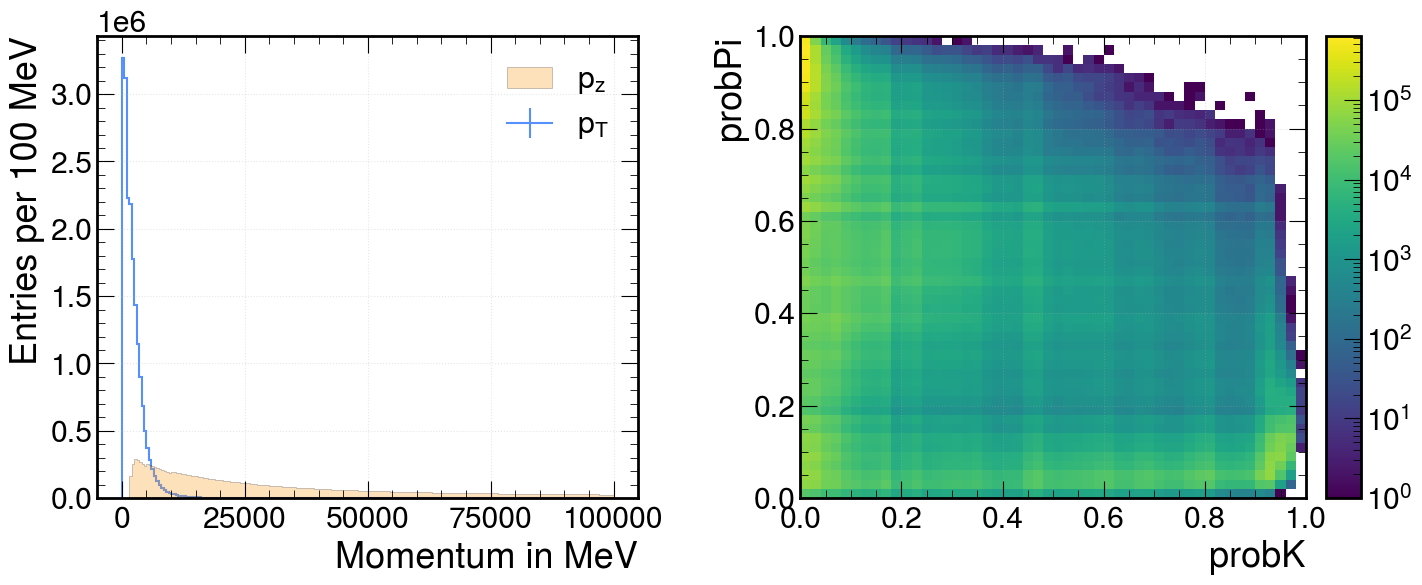

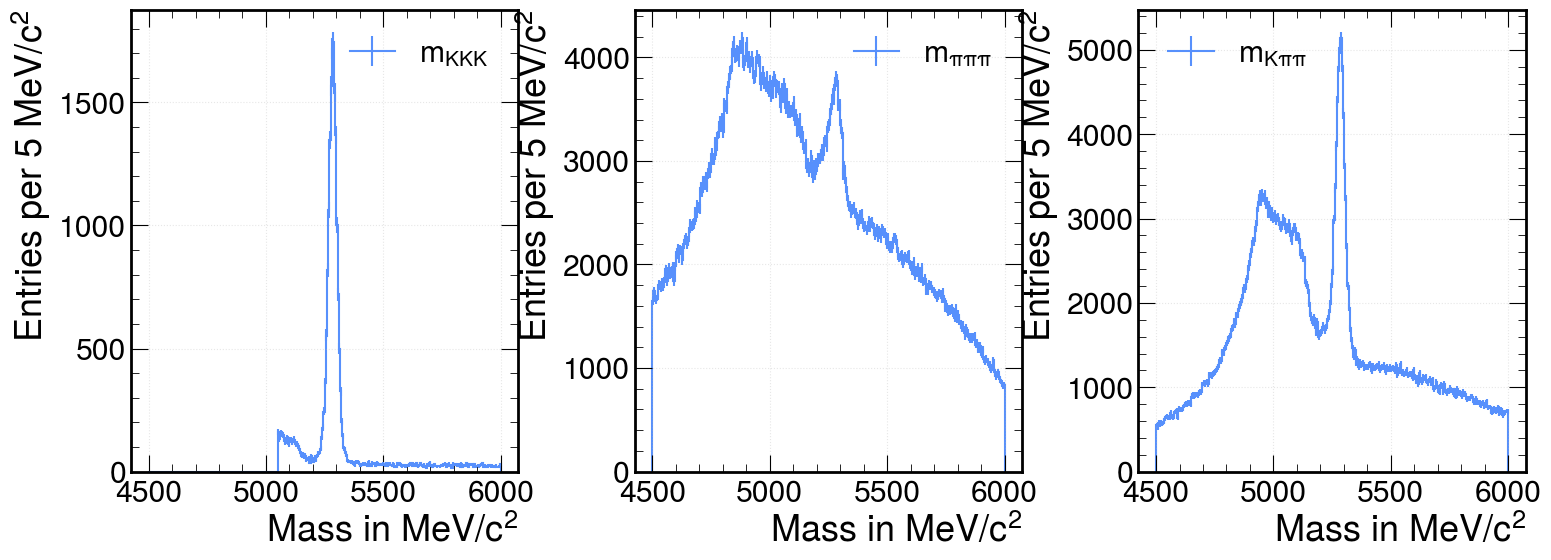

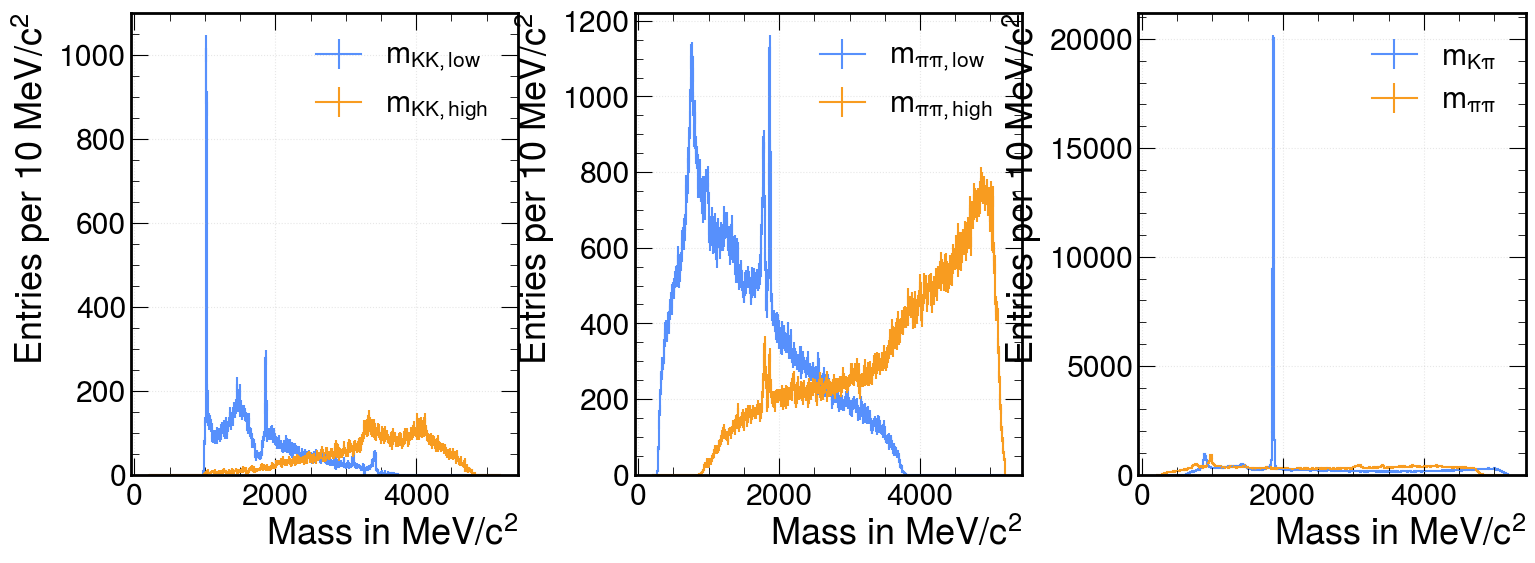

All histograms created successfully with pure ROOT RDataFrame!


Info in <TH1F::SaveAs>: ROOT file rdfs_pT_hist.root has been created
Info in <TH1F::SaveAs>: ROOT file rdfs_pZ_hist.root has been created
Info in <TH2F::SaveAs>: ROOT file rdfs_prob2D_hist.root has been created
Info in <TH1D::SaveAs>: ROOT file rdfs_mKKlow_hist.root has been created
Info in <TH1D::SaveAs>: ROOT file rdfs_mKKhigh_hist.root has been created
Info in <TH1D::SaveAs>: ROOT file rdfs_mpipilow_hist.root has been created
Info in <TH1D::SaveAs>: ROOT file rdfs_mpipihigh_hist.root has been created
Info in <TH1D::SaveAs>: ROOT file rdfs_mKpi_hist.root has been created
Info in <TH1D::SaveAs>: ROOT file rdfs_mpipi_kpi_hist.root has been created


In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep  

print("Creating histograms with ROOT RDataFrame...")

# Enable implicit multi-threading in ROOT
plt.style.use(hep.style.ROOT)

# ======================
# 1. pT ve pZ histogramları + 2D probK vs probPi
# ======================
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig1.subplots_adjust(wspace=0.3)

print('Plotting 1D histogram - pT and pZ')

# ROOT histogramları oluştur
h_pT = ROOT.TH1F("h_pT", "p_{T} Distribution", 200, 0, 100000)
h_pZ = ROOT.TH1F("h_pZ", "p_{z} Distribution", 200, 0, 100000)

# RDataFrame'den doğrudan ROOT histogramları oluştur
print("Creating pT and pZ histograms from RDataFrame...")

# pT için histogramlar
h_pT1 = df_basic.Histo1D(("h_pT1", "pT_H1", 200, 0, 100000), "pT_H1")
print(h_pT1)
print(h_pT1.GetEntries())
h_pT2 = df_basic.Histo1D(("h_pT2", "pT_H2", 200, 0, 100000), "pT_H2")
h_pT3 = df_basic.Histo1D(("h_pT3", "pT_H3", 200, 0, 100000), "pT_H3")

# pZ için histogramlar
h_pZ1 = df_basic.Histo1D(("h_pZ1", "H1_PZ", 200, 0, 100000), "H1_PZ")
h_pZ2 = df_basic.Histo1D(("h_pZ2", "H2_PZ", 200, 0, 100000), "H2_PZ")
h_pZ3 = df_basic.Histo1D(("h_pZ3", "H3_PZ", 200, 0, 100000), "H3_PZ")

# Histogramları birleştir
h_pT.Add(h_pT1.GetValue())
h_pT.Add(h_pT2.GetValue())
h_pT.Add(h_pT3.GetValue())

h_pZ.Add(h_pZ1.GetValue())
h_pZ.Add(h_pZ2.GetValue())
h_pZ.Add(h_pZ3.GetValue())

# mplhep ile histogramları çiz
hep.histplot(h_pT, ax=ax1[0], histtype='step', label='$p_{T}$', linewidth=1.5)
hep.histplot(h_pZ, ax=ax1[0], histtype='fill', label='$p_{z}$',alpha=0.3, edgecolor='black', linewidth=0.5)

# ROOT histogram verilerini kaydet
h_pT.SaveAs("rdfs_pT_hist.root")
h_pZ.SaveAs("rdfs_pZ_hist.root")
print(f"ROOT pT histogram: {h_pT.GetEntries()} entries saved")
print(f"ROOT pZ histogram: {h_pZ.GetEntries()} entries saved")

ax1[0].set_xlabel('Momentum in MeV')
ax1[0].set_ylabel('Entries per 100 MeV')
ax1[0].legend()
ax1[0].grid(True, alpha=0.3)

print('Plotting 2D histogram - probK vs probPi')

# 2D ROOT histogramlarını oluştur ve birleştir
h2d_prob1 = df_basic.Histo2D(("h2d_prob1", "H1_ProbK vs H1_ProbPi", 50, 0, 1, 50, 0, 1), "H1_ProbK", "H1_ProbPi")
h2d_prob2 = df_basic.Histo2D(("h2d_prob2", "H2_ProbK vs H2_ProbPi", 50, 0, 1, 50, 0, 1), "H2_ProbK", "H2_ProbPi")
h2d_prob3 = df_basic.Histo2D(("h2d_prob3", "H3_ProbK vs H3_ProbPi", 50, 0, 1, 50, 0, 1), "H3_ProbK", "H3_ProbPi")


# Yeni bir histogram oluştur ve diğerlerini buna ekle
h2d_prob = ROOT.TH2F("h2d_prob", "probK vs probPi;probK;probPi", 50, 0, 1, 50, 0, 1)
h2d_prob.Add(h2d_prob1.GetValue())
h2d_prob.Add(h2d_prob2.GetValue())
h2d_prob.Add(h2d_prob3.GetValue())

# mplhep ile 2D histogram çiz
hep.hist2dplot(h2d_prob, ax=ax1[1], norm=colors.LogNorm())
ax1[1].set_xlabel('probK')
ax1[1].set_ylabel('probPi')
ax1[1].grid(True, alpha=0.3)

# ROOT 2D histogram kaydet
h2d_prob.SaveAs("rdfs_prob2D_hist.root")
print(f"ROOT 2D histogram: {h2d_prob.GetEntries()} entries saved")

plt.savefig('momentum_prob_histograms.pdf')
print('Saved momentum_prob_histograms.pdf')

# ======================
# 2. Üçlü kütle dağılımları (orijinal histogramlar)
# ======================
fig2, ax2 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig2.subplots_adjust(wspace=0.3)

print('Plotting triple mass distributions')

# KKK mass distribution
if kkk_selected > 0:
    h_kkk_mass = df_kkk_selected.Histo1D(("h_kkk_mass", "KKK mass", 300, 4500, 6000), "KKK_valid_mass").GetValue()
    hep.histplot(h_kkk_mass, ax=ax2[0], histtype='step', label='$m_{KKK}$')
    print(f"KKK mass histogram entries: {h_kkk_mass.GetEntries()}")
else:
    print("Warning: No KKK events to plot")
    
# πππ mass distribution
if pipipi_selected > 0:
    h_pipipi_mass = df_pipipi_selected.Histo1D(("h_pipipi_mass", "πππ mass", 300, 4500, 6000), "PIPIPI_valid_mass").GetValue()
    hep.histplot(h_pipipi_mass, ax=ax2[1], histtype='step', label='$m_{\pi\pi\pi}$')
    print(f"πππ mass histogram entries: {h_pipipi_mass.GetEntries()}")
else:
    print("Warning: No πππ events to plot")
    
# Kππ mass distribution
if kpi_selected > 0:
    h_kpi_mass = df_kpi_selected.Histo1D(("h_kpi_mass", "Kππ mass", 300, 4500, 6000), "kpi_valid_mass").GetValue()
    hep.histplot(h_kpi_mass, ax=ax2[2], histtype='step', label='$m_{K\pi\pi}$')
    print(f"Kππ mass histogram entries: {h_kpi_mass.GetEntries()}")
else:
    print("Warning: No Kππ events to plot")

for i in range(3):
    ax2[i].set_xlabel('Mass in MeV/$c^2$')
    ax2[i].set_ylabel('Entries per 5 MeV/$c^2$')
    ax2[i].legend()
    ax2[i].grid(True, alpha=0.3)

plt.savefig('triple_mass_distributions.pdf')
print('Saved triple_mass_distributions.pdf')

# ======================
# 3. Eksik olan orijinal histogramlar (mKK, mpipi, mKpi)
# ======================
fig3, ax3 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig3.subplots_adjust(wspace=0.3)

print('Plotting original missing histograms - mKK, mpipi, mKpi')

# KKK - mKK low and high distributions
if kkk_mass_window > 0:
    h_mKKlow = df_kkk_mass_window.Histo1D(("h_mKKlow", "KK low mass", 500, 200, 5200), "KKK_mlow").GetValue()
    h_mKKhigh = df_kkk_mass_window.Histo1D(("h_mKKhigh", "KK high mass", 500, 200, 5200), "KKK_mhigh").GetValue()
    
    hep.histplot(h_mKKlow, ax=ax3[0], histtype='step', label='$m_{KK,low}$', linewidth=1.5)
    hep.histplot(h_mKKhigh, ax=ax3[0], histtype='step', label='$m_{KK,high}$', linewidth=1.5)
    
    print(f"mKKlow histogram entries: {h_mKKlow.GetEntries()}")
    print(f"mKKhigh histogram entries: {h_mKKhigh.GetEntries()}")
    
    # ROOT histogramları kaydet
    h_mKKlow.SaveAs("rdfs_mKKlow_hist.root")
    h_mKKhigh.SaveAs("rdfs_mKKhigh_hist.root")
else:
    print("Warning: No KKK mass window events for mKK histograms")

# πππ - mpipi low and high distributions
if pipipi_mass_window > 0:
    h_mpipilow = df_pipipi_mass_window.Histo1D(("h_mpipilow", "ππ low mass", 500, 200, 5200), "PIPIPI_mlow").GetValue()
    h_mpipihigh = df_pipipi_mass_window.Histo1D(("h_mpipihigh", "ππ high mass", 500, 200, 5200), "PIPIPI_mhigh").GetValue()
    
    hep.histplot(h_mpipilow, ax=ax3[1], histtype='step', label='$m_{\pi\pi,low}$', linewidth=1.5)
    hep.histplot(h_mpipihigh, ax=ax3[1], histtype='step', label='$m_{\pi\pi,high}$', linewidth=1.5)
    
    print(f"mpipilow histogram entries: {h_mpipilow.GetEntries()}")
    print(f"mpipihigh histogram entries: {h_mpipihigh.GetEntries()}")
    
    # ROOT histogramları kaydet
    h_mpipilow.SaveAs("rdfs_mpipilow_hist.root")
    h_mpipihigh.SaveAs("rdfs_mpipihigh_hist.root")
else:
    print("Warning: No πππ mass window events for mpipi histograms")

# Kππ - mKpi and mpipi distributions
if kpi_mass_window > 0:
    h_mKpi = df_kpi_mass_window.Histo1D(("h_mKpi", "Kπ mass", 500, 200, 5200), "kpi_mKpi").GetValue()
    h_mpipi_kpi = df_kpi_mass_window.Histo1D(("h_mpipi_kpi", "ππ mass in Kππ", 500, 200, 5200), "kpi_mpipi").GetValue()
    
    hep.histplot(h_mKpi, ax=ax3[2], histtype='step', label='$m_{K\pi}$', linewidth=1.5)
    hep.histplot(h_mpipi_kpi, ax=ax3[2], histtype='step', label='$m_{\pi\pi}$', linewidth=1.5)
    
    print(f"mKpi histogram entries: {h_mKpi.GetEntries()}")
    print(f"mpipi (Kππ) histogram entries: {h_mpipi_kpi.GetEntries()}")
    
    # ROOT histogramları kaydet
    h_mKpi.SaveAs("rdfs_mKpi_hist.root")
    h_mpipi_kpi.SaveAs("rdfs_mpipi_kpi_hist.root")
else:
    print("Warning: No Kππ mass window events for mKpi histograms")

# Eksen etiketleri ve grid
for i in range(3):
    ax3[i].set_xlabel('Mass in MeV/$c^2$')
    ax3[i].set_ylabel('Entries per 10 MeV/$c^2$')
    ax3[i].legend()
    ax3[i].grid(True, alpha=0.3)

plt.savefig('missing_original_histograms.pdf')
print('Saved missing_original_histograms.pdf')

plt.show()

print("All histograms created successfully with pure ROOT RDataFrame!")